# Notebook for results analysis of GAN training. 

In [1]:
#Import of necessary packages and memory allocation.
%matplotlib inline

import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(1)
set_session(tf.Session(config=config))
import time
import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

import sys
import seaborn as sns
import math
from sklearn.decomposition import PCA
#s = np.random.seed(1)

Using TensorFlow backend.


In [2]:

import cartopy
import cartopy.crs as ccrs
import cartopy.util

In [3]:
#Plot parameters
sns.set() #Seaborn theme 

from matplotlib import rc
font = {'family' : 'normal','weight' : 'bold', 'size'   : 22}
tick_size = 20
fontweight = 'bold'
#lab_loc = 2
#lab_font_size = 14
#rc('text', usetex=True)
matplotlib.rc('font', **font)
plt.style.use('seaborn')

## Path managment

folderpath is the folder in which you cloned the github repository


In [4]:
data_folder = '../../Puma_Project/data/raw/'
model_path = '../model/RESNET_V8_82l_continue4_generator.h5'

## Parameters. 

Setting up parameters for figure generations 

In [5]:
#########
plot_var = True    #True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

years = 1
N_train = 360*years
N_gen = 360*years     #Number of generation used for statistic analysis /!\ Memory usage important /!\
scaled = False


## Loading database

In [6]:
# Creation of channel list
if N_fields==82:
    var = ['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
    lvls = [100, 200,300,400,500,600,700,800,900,1000]

chan_titles = [i+'_z'+str(j) for i in var for j in lvls]
chan_titles.append('surf_press')
chan_titles.append('latitudes')
print(chan_titles)
print(len(chan_titles))

['ta_z100', 'ta_z200', 'ta_z300', 'ta_z400', 'ta_z500', 'ta_z600', 'ta_z700', 'ta_z800', 'ta_z900', 'ta_z1000', 'ua_z100', 'ua_z200', 'ua_z300', 'ua_z400', 'ua_z500', 'ua_z600', 'ua_z700', 'ua_z800', 'ua_z900', 'ua_z1000', 'va_z100', 'va_z200', 'va_z300', 'va_z400', 'va_z500', 'va_z600', 'va_z700', 'va_z800', 'va_z900', 'va_z1000', 'hus_z100', 'hus_z200', 'hus_z300', 'hus_z400', 'hus_z500', 'hus_z600', 'hus_z700', 'hus_z800', 'hus_z900', 'hus_z1000', 'wap_z100', 'wap_z200', 'wap_z300', 'wap_z400', 'wap_z500', 'wap_z600', 'wap_z700', 'wap_z800', 'wap_z900', 'wap_z1000', 'zeta_z100', 'zeta_z200', 'zeta_z300', 'zeta_z400', 'zeta_z500', 'zeta_z600', 'zeta_z700', 'zeta_z800', 'zeta_z900', 'zeta_z1000', 'd_z100', 'd_z200', 'd_z300', 'd_z400', 'd_z500', 'd_z600', 'd_z700', 'd_z800', 'd_z900', 'd_z1000', 'zg_z100', 'zg_z200', 'zg_z300', 'zg_z400', 'zg_z500', 'zg_z600', 'zg_z700', 'zg_z800', 'zg_z900', 'zg_z1000', 'surf_press', 'latitudes']
82


In [7]:
#########
lons = np.genfromtxt(f'{data_folder}lon.csv', delimiter=',')
lats = np.genfromtxt(f'{data_folder}lat.csv', delimiter=',')


lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']

#Loading dataset and scaling factors (N_fields, 2)= mean and variance for each channel.
if N_fields==82:
    f=h5.File(f'{data_folder}T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])


print(scaling.shape)

(81, 2)


## Loads dataset samples and generates sample from the generator

The following cell is loading the trained generator, generates samples (same number as samples loaded in the dataset '*years*' parameter define above), scales the generation and the dataset if the flag defined above is True.

In [8]:
import random
sys.path.append('../src/modeling')

sys.path.append('../src/preprocessing')

sys.path.append('../src/preparation')
from SpectralNormalizationKeras import *
from custom_classes import *
from data_preproc import *
indexes = random.sample(range(0,_X_train.shape[0]), N_train)

#from data_preproc import *


gen = load_model(f'{model_path}',custom_objects = {'NearestPadding2D': NearestPadding2D,'WrapPadding2D': WrapPadding2D, 'DenseSN' :DenseSN, 'ConvSN2D': ConvSN2D})
gen._make_predict_function()


print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
if scaled:
    fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                          scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')
print('Database loading...')

if N_fields==82:
    f=h5.File(f'{data_folder}T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])
    
print('Database loaded.')

print('Scaling...')
if scaled:
    X_train = np.multiply(_X_train[np.sort(indexes),:,:,:],
                          scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
else:
    X_train = _X_train[:N_train]
print('Scaled')

#noise_ = np.load('./fig_82c/noise_.npy')
#im = gen.predict(noise_)
#im_sc = np.multiply(im[:,:,:,:-1],
#                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]




/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Generating samples...
Samples generated.
scaling...
scaled.
Database loading...
Database loaded.
Scaling...
Scaled


In [9]:
#Creates the lattitudes fields in order to concatenate it to the database (as it was done during the WGAN training).

from mpl_toolkits.axes_grid1 import make_axes_locatable

lon=lons
lat=lats
#llat = np.load('../data/raw/llat.npy')
#lat = np.arange(-1,1,2./64.).reshape(64)
llat = np.expand_dims(lat, axis = 0)
llat = np.expand_dims(llat, axis = -1)
llat = llat.repeat(N_train, axis = 0)
llat = llat.repeat(128, axis = 2)


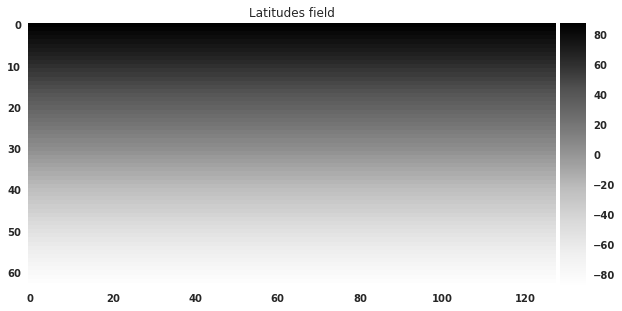

In [10]:
plt.figure(figsize=(10,10))
plt.title('Latitudes field')
plt.grid(False)
ax = plt.gca()
im = ax.imshow(llat[0,:,:])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

In [11]:
print(llat.shape)
X_train = np.concatenate((X_train, llat.reshape(N_train,64,128,1)), axis=-1)
print(X_train.shape)

(360, 64, 128)
(360, 64, 128, 82)


## Mean and std comparison between generations and dataset

In [12]:
mean_err = (np.mean(fk_imgs, axis=0) - np.mean(X_train, axis=0))
std_err = (np.std(fk_imgs, axis=0) - np.std(X_train, axis=0))

std_err_ratio = np.std(fk_imgs, axis=0)/np.std(X_train, axis=0)

/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [13]:
vmax = np.amax(mean_err)
vmin = np.amin(mean_err)
print(vmin, vmax)

amax = np.amax(mean_err[:,:,:-1])
amin = np.amin(mean_err[:,:,:-1])

largerm = max(np.abs(amin), np.abs(amax))
vmmin, vmmax = -largerm, largerm
print(vmmin, vmmax)

amax = np.amax(std_err[:,:,:-2])
amin = np.amin(std_err[:,:,:-2])

largers = max(np.abs(amin), np.abs(amax))
vsmin, vsmax = -largers, largers
print(vsmin, vsmax)

-1.0729287832095804 1.1171056221239268
-1.1171056221239268 1.1171056221239268
-1.240905911824084 1.240905911824084


0.003089642098788696


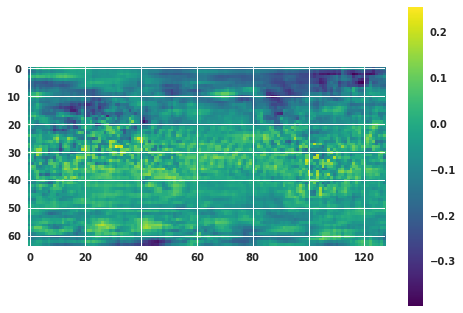

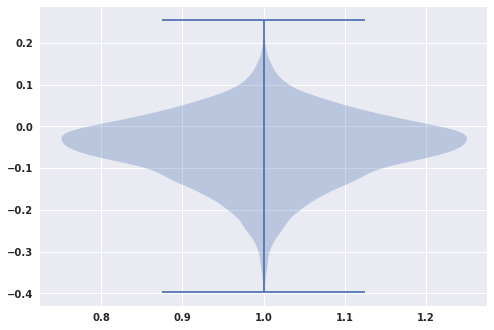

In [14]:
plt.imshow(mean_err[:,:,9], cmap = 'viridis')
plt.colorbar()

print(np.mean(mean_err[:,:,0]))
plt.figure()
hist = plt.violinplot(mean_err[:,:,9].reshape(-1))



In [15]:
print(mean_err[:,:,0])
print(mean_err[:,:,0].max())
print(mean_err[:,:,0].min())

[[-0.08910412 -0.14075259 -0.14639563 ... -0.11549645 -0.10163895
  -0.09342722]
 [-0.06556095 -0.10684042 -0.1178395  ... -0.0855502  -0.05860114
  -0.06509621]
 [-0.03803003 -0.09312336 -0.10905386 ... -0.04025126 -0.02520255
  -0.02148724]
 ...
 [ 0.06869373  0.07068927  0.06290852 ...  0.08210392  0.06232111
   0.05215529]
 [ 0.15333758  0.15558845  0.15690273 ...  0.08466037  0.06966207
   0.10690111]
 [ 0.28520348  0.30816526  0.29858121 ...  0.22707737  0.20156143
   0.24943198]]
0.45562524600213183
-0.4460546718050157


L :  [9, 4, 0, 19, 14, 10, 29, 24, 20, 39, 34, 30, 49, 44, 40, 59, 54, 50, 69, 64, 60, 79, 74, 70, -2, -1]


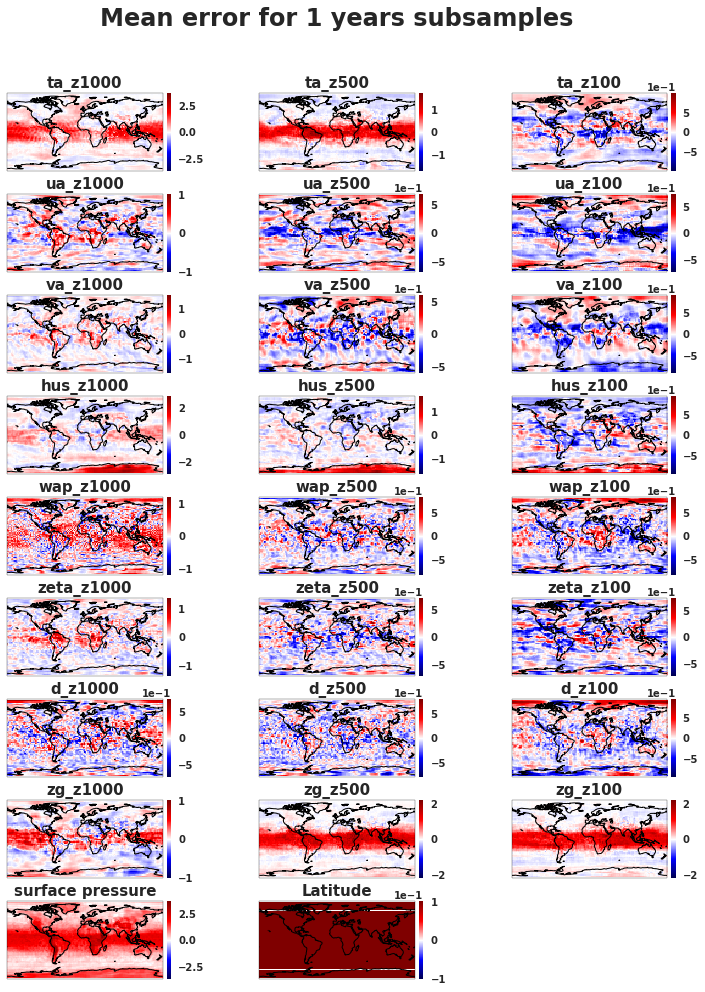

In [16]:
from matplotlib.colors import LogNorm

cm = ['rocket','rocket','rocket','rocket','rocket','rocket','Blues','Blues','Blues','Purples','Purples','Purples',
      'PuRd','PuRd','PuRd','copper','copper','copper','viridis','viridis','viridis',
      'Greens_r','Greens_r','Greens_r' ,'Greys']
cm = ['seismic']*9*3



if N_fields == 82:
    v1,v2,v3 = 9,4,0

    L = [v1, v2, v3, v1+N_lvls, v2+N_lvls, v3+N_lvls, v1+2*N_lvls, v2+2*N_lvls, v3+2*N_lvls,
         v1+3*N_lvls, v2+3*N_lvls, v3+3*N_lvls, v1+4*N_lvls, v2+4*N_lvls, v3+4*N_lvls,
         v1+5*N_lvls, v2+5*N_lvls, v3+5*N_lvls, v1+6*N_lvls, v2+6*N_lvls, v3+6*N_lvls,
         v1+7*N_lvls, v2+7*N_lvls, v3+7*N_lvls, -2, -1]

cnt = 1

print('L : ',L)
fig, ax = plt.subplots(nrows = 9, ncols = 3, figsize=(12,15),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(1,-1)
fig.suptitle(f'Mean error for {years} years subsamples', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.35, hspace = 0.3)

for k in L:
    amax = np.amax(np.log(std_err_ratio[:,:,k]))
    amin = np.amin(np.log(std_err_ratio[:,:,k]))

    largers = max(np.abs(amin), np.abs(amax))
    vsmin, vsmax = -largers, largers
    #print(vsmin, vsmax)
    ax[0,cnt-1].coastlines(linewidth = 1)
    
    im = ax[0,cnt-1].imshow(np.log(std_err_ratio[::-1,:,k]), cmap=cm[cnt-1], vmin=vsmin, vmax = vsmax,
                            transform=ccrs.PlateCarree(central_longitude=180.))

    ax[0,cnt-1].set_title(chan_titles[k], fontsize = 15, fontweight = fontweight)

    posn = ax[0,cnt-1].get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.005, posn.y0, 0.005, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    
    ax[0,cnt-1].grid(False)
    cnt+=1

ax[0,-2].set_title('Latitude', fontsize = 15, fontweight = fontweight)
ax[0,-3].set_title('surface pressure', fontsize = 15, fontweight = fontweight)

ax[0,-1].remove()

if save:
    plt.savefig(f'./fig_{N_fields}c/Std_ratio_error_{years}.pdf')

[9, 4, 0, 39, 34, 30, 49, 44, 40, 59, 54, 50, 79, 74, 70, -2]


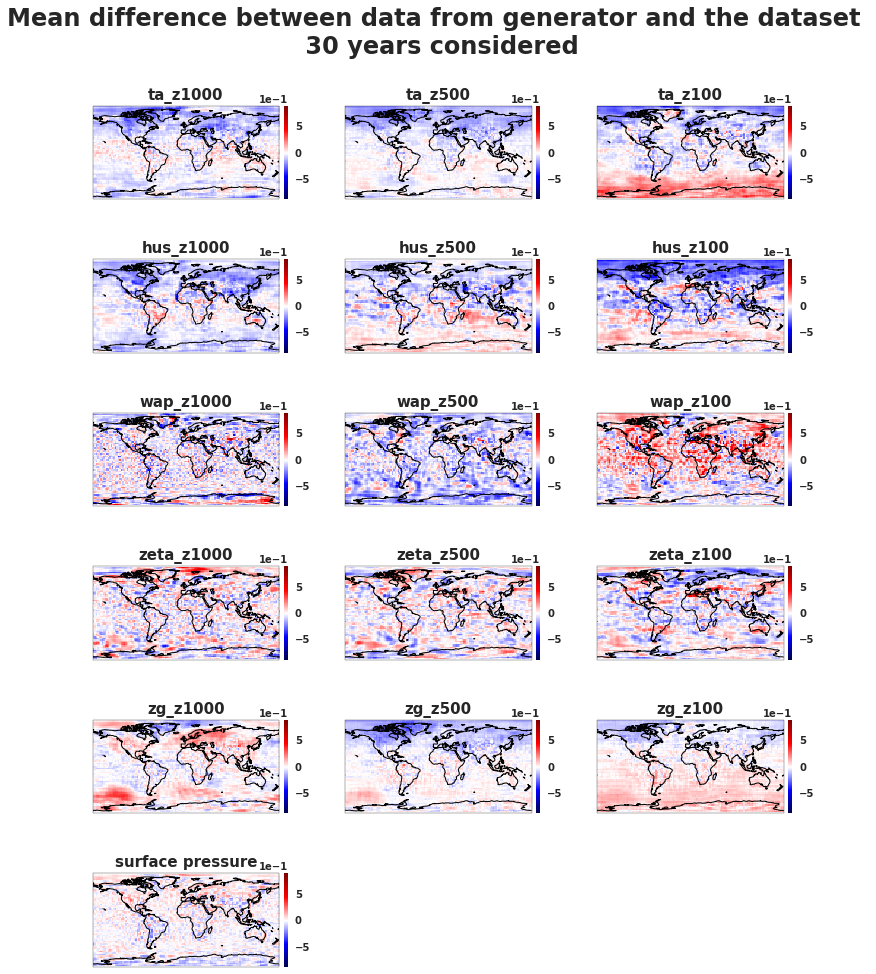

In [17]:
cm = ['rocket','rocket','rocket','rocket','rocket','rocket','Blues','Blues','Blues','Purples','Purples','Purples',
      'PuRd','PuRd','PuRd','copper','copper','copper','viridis','viridis','viridis',
      'Greens_r','Greens_r','Greens_r' ,'Greys']
cm = ['seismic']*9*3

if N_fields == 82:
    v1,v2,v3 = 9,4,0
    L = [v1, v2, v3,
         v1+3*N_lvls, v2+3*N_lvls, v3+3*N_lvls, v1+4*N_lvls, v2+4*N_lvls, v3+4*N_lvls,
         v1+5*N_lvls, v2+5*N_lvls, v3+5*N_lvls,
         v1+7*N_lvls, v2+7*N_lvls, v3+7*N_lvls, -2]

amax = np.amax(mean_err[:,:,L])
amin = np.amin(mean_err[:,:,L])

larger = max(np.abs(amin), np.abs(amax))
cnt = 1

print(L)
fig, ax = plt.subplots(nrows = 6, ncols = 3, figsize=(12,15),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(1,-1)
fig.suptitle(f'Mean difference between data from generator and the dataset \n 30 years considered', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.35, hspace = 0.3)

for k in L:
    vmin = -max(np.abs(np.amin(mean_err[:,:,k])), np.amax(mean_err[:,:,k]))
    vmax = -vmin
    ax[0,cnt-1].coastlines(linewidth = 1)
    im = ax[0,cnt-1].imshow(mean_err[::-1,:,k], cmap=cm[cnt-1],vmin=-larger, vmax = larger,
                            transform=ccrs.PlateCarree(central_longitude=180.))

    ax[0,cnt-1].set_title(chan_titles[k], fontsize = 15, fontweight = fontweight)

    posn = ax[0,cnt-1].get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.005, posn.y0, 0.005, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    
    ax[0,cnt-1].grid(False)
    cnt+=1

ax[0,-2].set_title('Latitude', fontsize = 15, fontweight = fontweight)
ax[0,-3].set_title('surface pressure', fontsize = 15, fontweight = fontweight)


ax[0,-2].remove()
ax[0,-1].remove()
if save:
    plt.savefig(f'./fig_{N_fields}c/Mean_error_{years}.pdf')   


Larger value :  1.240905911824084
[9, 4, 0, 39, 34, 30, 49, 44, 40, 59, 54, 50, 79, 74, 70, -2]


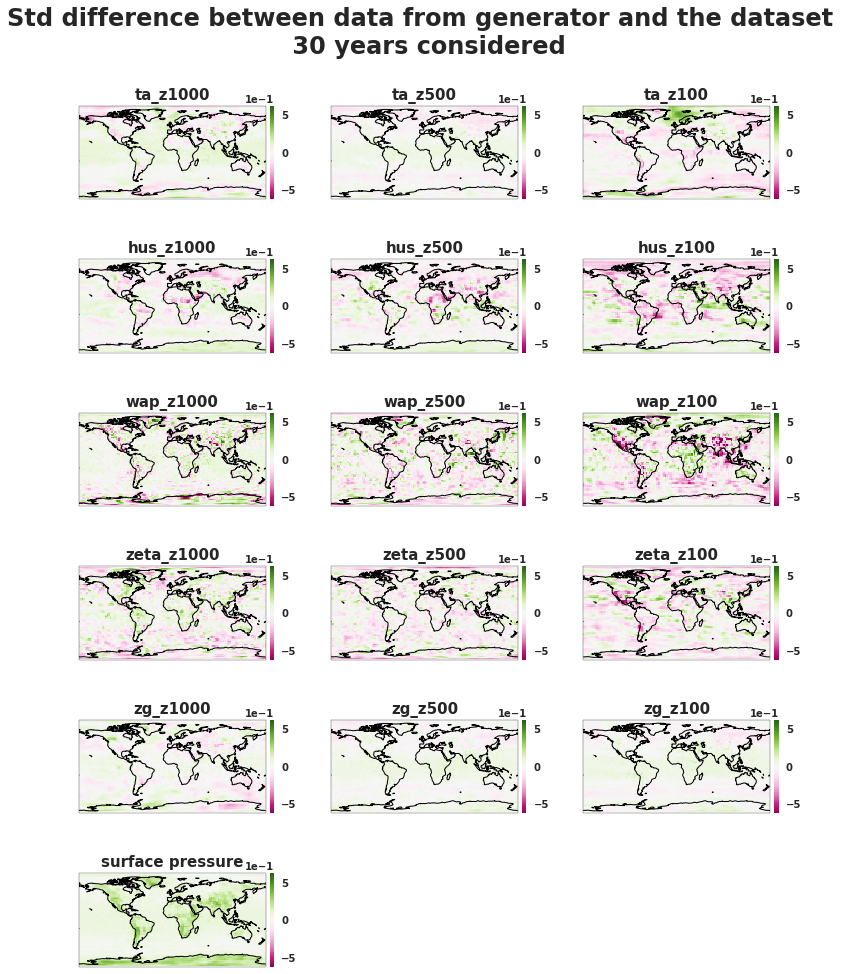

In [18]:
cm = ['rocket','rocket','rocket','rocket','rocket','rocket','Blues','Blues','Blues','Purples','Purples','Purples',
      'PuRd','PuRd','PuRd','copper','copper','copper','viridis','viridis','viridis',
      'Greens_r','Greens_r','Greens_r' ,'Greys']
cm = ['PiYG']*9*3
if N_fields == 22:
    v1,v2,v3 = 0,1,2
    L = [v1, v1+N_lvls, v1+3*N_lvls,
         v2, v2+N_lvls, v2+3*N_lvls,
         v3, v3+N_lvls, v3+3*N_lvls]
elif N_fields == 82:
    v1,v2,v3 = 9,4,0

    L = [v1, v2, v3,
         v1+3*N_lvls, v2+3*N_lvls, v3+3*N_lvls, v1+4*N_lvls, v2+4*N_lvls, v3+4*N_lvls,
         v1+5*N_lvls, v2+5*N_lvls, v3+5*N_lvls,
         v1+7*N_lvls, v2+7*N_lvls, v3+7*N_lvls, -2]
amax = np.amax(std_err[:,:,L])
amin = np.amin(std_err[:,:,L])

larger = max(np.abs(amin), np.abs(amax))
vmin, vmax = 0, larger
print('Larger value : ',larger)

print(L)
fig, ax = plt.subplots(nrows = 6, ncols = 3, figsize=(12,15),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(1,-1)
fig.suptitle(f'Std difference between data from generator and the dataset \n 30 years considered', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.35, hspace = 0.3)
cnt=1
for k in L:
    vmin = -max(np.abs(np.amin(std_err[:,:,k])), np.amax(std_err[:,:,k]))
    vmax = -vmin
    ax[0,cnt-1].coastlines(linewidth = 1)
    im = ax[0,cnt-1].imshow(std_err[::-1,:,k], cmap=cm[cnt-1], vmin=-larger*0.5, vmax=larger*0.5,
                            transform=ccrs.PlateCarree(central_longitude=180.))

    ax[0,cnt-1].set_title(chan_titles[k], fontsize = 15, fontweight = fontweight)

    posn = ax[0,cnt-1].get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.005, posn.y0, 0.005, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    
    ax[0,cnt-1].grid(False)
    #ax[0,cnt-2].grid(False)
    #ax[0,cnt-3].grid(False)
    #ax[0,cnt-4].grid(False)
    cnt+=1

#im = ax[0,-2].imshow(llat)
ax[0,-2].set_title('Latitude', fontsize = 15, fontweight = fontweight)
ax[0,-3].set_title('surface pressure', fontsize = 15, fontweight = fontweight)

ax[0,-2].remove()
ax[0,-1].remove()

if save:
    plt.savefig(f'./fig_{N_fields}c/Std_error_{years}.pdf')   

In [19]:
print(X_train.shape)
print(fk_imgs.shape)
print(mean_err.shape)
print(std_err.shape)

(360, 64, 128, 82)
(360, 64, 128, 82)
(64, 128, 82)
(64, 128, 82)


## SVD decomposition on dataset and generations, and comparison of the directions of eigenvectors

In [20]:
# which field to choose
field = 74
#Component to keep
Nc = 5

In [21]:
X = X_train[:,:,:,field]
Xg = fk_imgs[:,:,:,field]

meanX, stdX = np.mean(X, axis=(0,1,2), keepdims=True), np.std(X, axis=(0,1,2), keepdims=True)
meanXg, stdXg = np.mean(Xg, axis=(0,1,2), keepdims=True), np.std(Xg, axis=(0,1,2), keepdims=True)
print(X.shape, Xg.shape, meanX.shape, stdX.shape)

(360, 64, 128) (360, 64, 128) (1, 1, 1) (1, 1, 1)


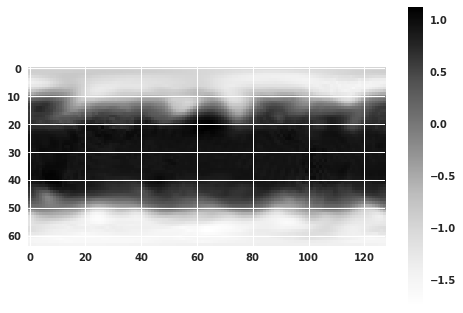

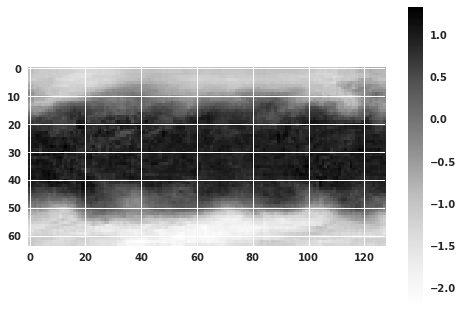

In [22]:
plt.figure()
plt.imshow(X[0,:,:])
plt.colorbar()

plt.figure()
plt.imshow(Xg[0,:,:])
plt.colorbar()

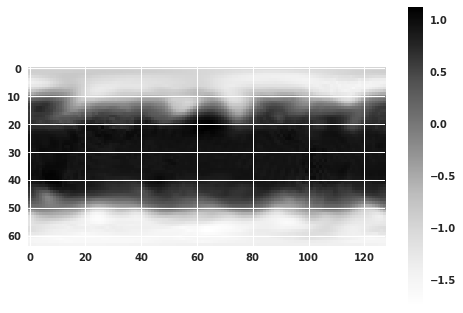

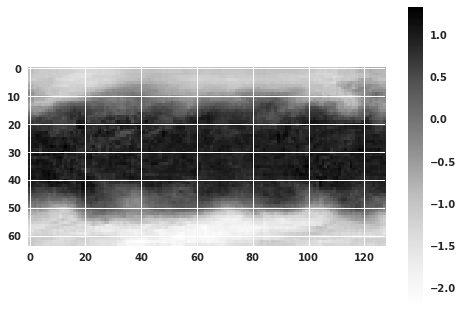

In [23]:
#X = (X - meanX)/stdX
#Xg = (Xg - meanXg)/stdXg

plt.figure()
plt.imshow(X[0,:,:])
plt.colorbar()

plt.figure()
plt.imshow(Xg[0,:,:])
plt.colorbar()

In [24]:
A = X.reshape(N_train,64*128)
Ag = Xg.reshape(N_gen,64*128)
from numpy import array
from sklearn.decomposition import TruncatedSVD
# define array
print(A)
# svd
svd = TruncatedSVD(n_components=Nc)
svd.fit(A)
At = svd.transform(A)
print(At.shape)
Agt = svd.transform(Ag)




[[-0.97008753 -0.9689281  -0.96782672 ... -1.45743024 -1.46105993
  -1.4646343 ]
 [-0.8356303  -0.83683318 -0.83817041 ... -1.44912088 -1.45215511
  -1.45512331]
 [-0.80723196 -0.80800265 -0.80879843 ... -1.44583642 -1.44996274
  -1.45400476]
 ...
 [-1.16134799 -1.16326761 -1.16548753 ... -1.26085627 -1.26544905
  -1.27019465]
 [-1.21589983 -1.21558094 -1.21569169 ... -1.00698364 -1.01205599
  -1.01723635]
 [-1.32350135 -1.32236445 -1.32173336 ... -0.82795203 -0.83135641
  -0.83509672]]
(360, 5)


In [25]:
print(svd.explained_variance_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[ 16.25128866 770.73373585  24.44929083  18.39591623  17.58413036]
0.7629559997002271
[1587.04940997  526.75494951   93.86595631   81.39344015   79.5663084 ]


(360, 64, 128)


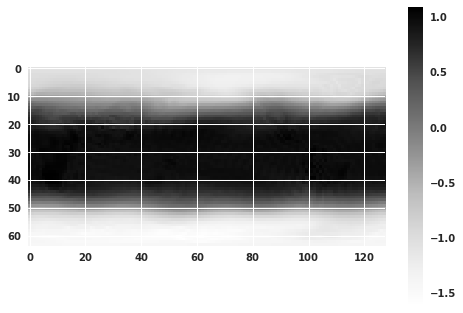

In [26]:
Ar = svd.inverse_transform(At).reshape(X.shape)
print(Ar.shape)
plt.imshow(Ar[0,:,:])
plt.colorbar()

(360, 64, 128)


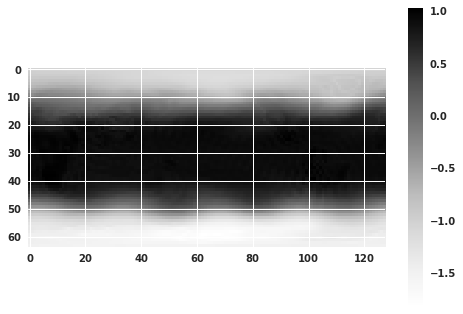

In [27]:
Agr = svd.inverse_transform(Agt).reshape(Xg.shape)
print(Agr.shape)
plt.imshow(Agr[0,:,:])
plt.colorbar()

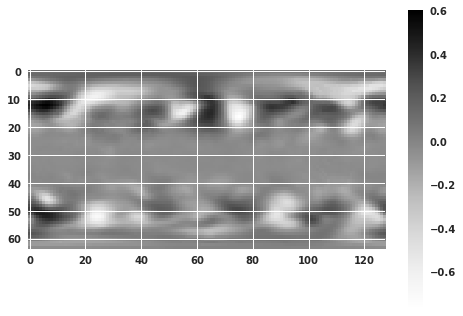

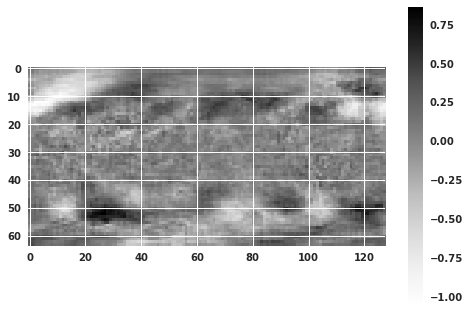

In [28]:
plt.figure()
plt.imshow((X-Ar)[0,:,:])
plt.colorbar()

plt.figure()
plt.imshow((Xg-Agr)[0,:,:])
plt.colorbar()

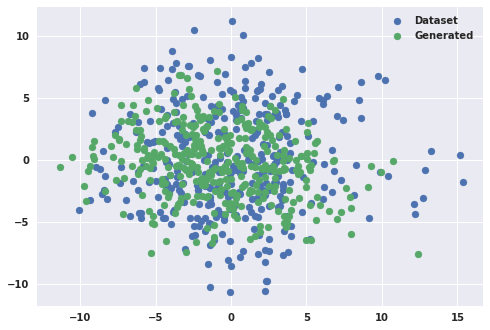

In [29]:
compo1 = 3
compo2 = 4
plt.figure()
plt.scatter(At[:,compo1], At[:,compo2], color='b')
plt.scatter(Agt[:,compo1], Agt[:,compo2], color='g')
plt.legend(['Dataset', 'Generated'])


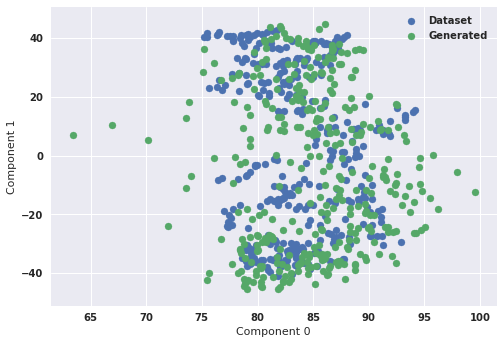

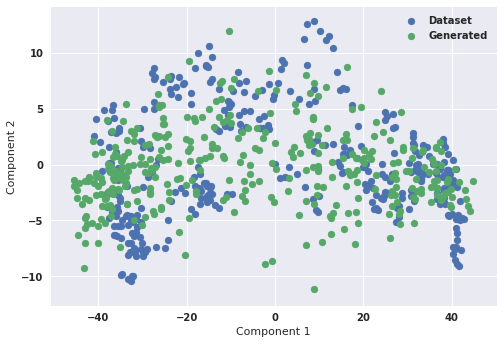

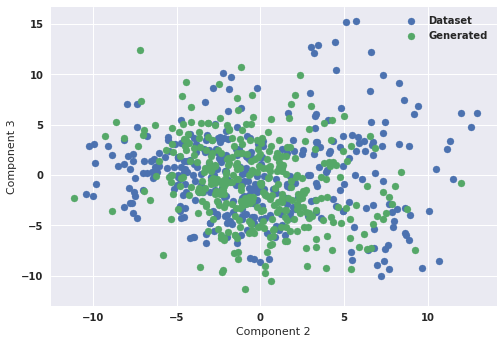

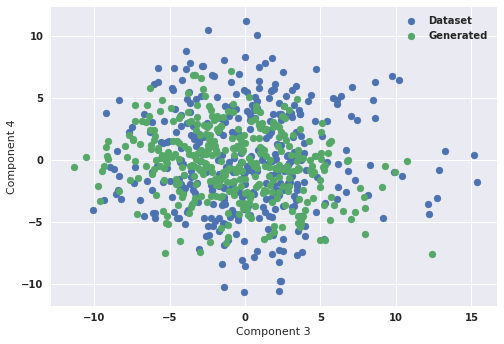

In [30]:
for i in range(Nc-1):
    compo1 = i
    compo2 = i+1
    plt.figure()
    plt.scatter(At[:,compo1], At[:,compo2], color='b')
    plt.scatter(Agt[:,compo1], Agt[:,compo2], color='g')
    plt.legend(['Dataset', 'Generated'])
    plt.xlabel(f'Component {compo1}')
    plt.ylabel(f'Component {compo2}')    

In [31]:
dfd = pd.DataFrame(At, columns=[f'Component{i}' for i in range(Nc)])
dfd['parameter'] = 'dataset'
dfg = pd.DataFrame(Agt, columns=[f'Component{i}' for i in range(Nc)])
dfg['parameter'] = 'generated'
dfg.head()
frames = [dfd,dfg]

df = pd.concat(frames)
print(df.shape)
df.head()

(720, 6)


,Component0,Component1,Component2,Component3,Component4,parameter
0,83.732552,-9.763304,-2.602077,-0.646796,-4.332513,dataset
1,83.242869,-10.806890,-2.625276,-0.465697,-4.879118,dataset
2,82.918155,-12.708006,-3.897749,-0.620272,-5.935146,dataset
3,82.842550,-13.533709,-3.625271,-1.370250,-6.834747,dataset
4,82.250943,-14.333090,-2.593256,0.563821,-7.801487,dataset


Text(0.5, 0.98, 'Component projection of SVD over 1 years simulated and generated')

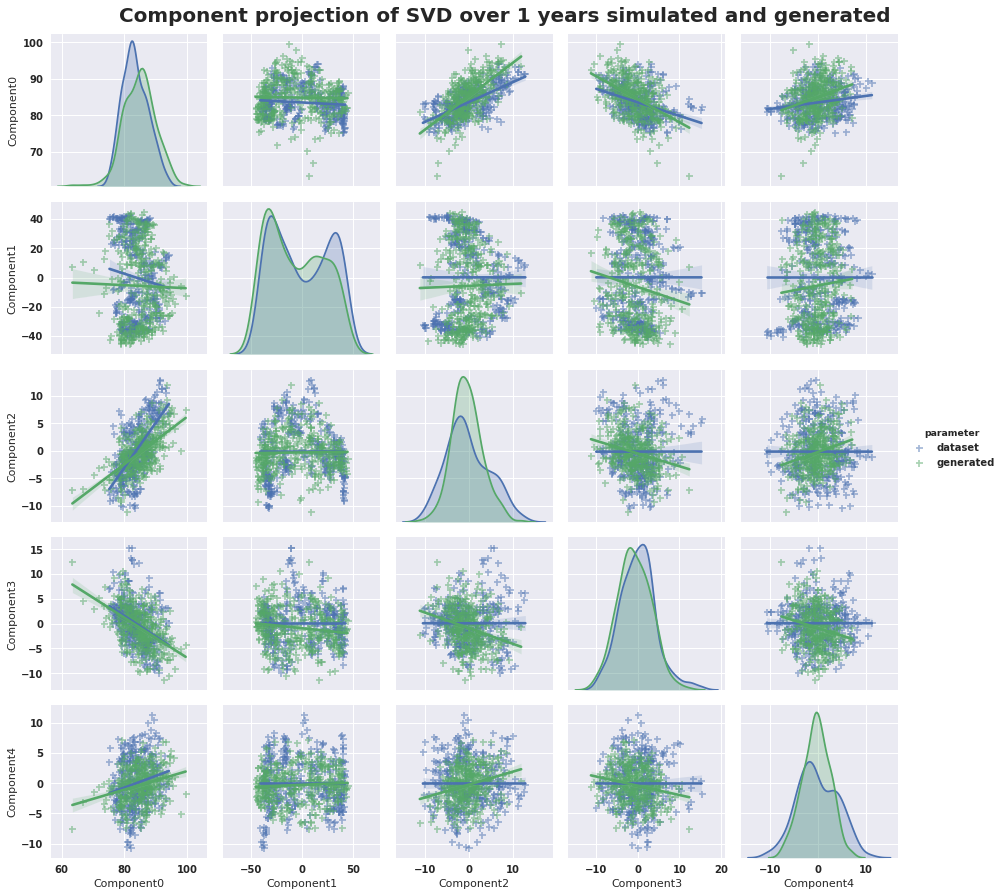

In [33]:
g = sns.pairplot(df, hue='parameter', markers='+', kind='reg', plot_kws={'scatter_kws': {'alpha': 0.5}})
g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.1)
g.fig.suptitle(f'Component projection of SVD over {years} years simulated and generated', fontsize=20, fontweight='bold')
#plt.savefig('./fig_82c/SVD_compo_proj_30y.png')


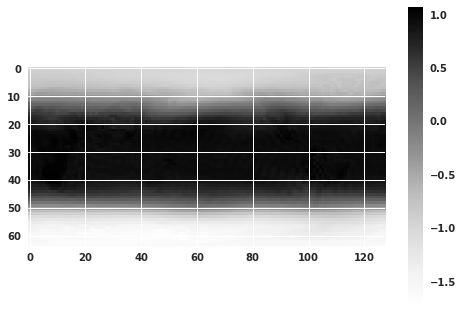

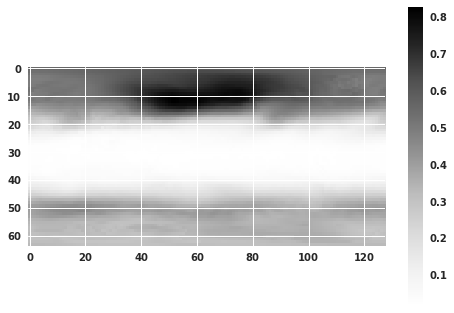

In [34]:
mX = np.mean(X, axis=0)
sX = np.std(X,axis=0)
plt.figure()
plt.imshow(mX)
plt.colorbar()
plt.figure()
plt.imshow(sX)
plt.colorbar()

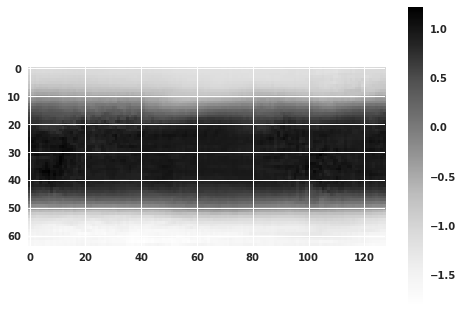

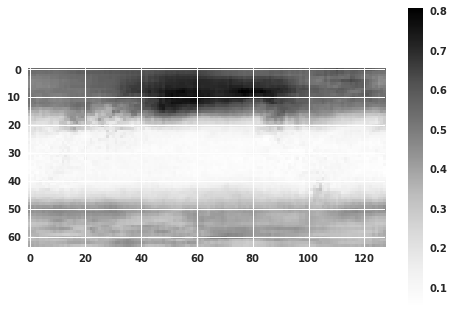

In [35]:
mXg = np.mean(Xg, axis=0)
sXg = np.std(Xg, axis=0)
plt.figure()
plt.imshow(mXg)
plt.colorbar()
plt.figure()
plt.imshow(sXg)
plt.colorbar()

[0.07419923 0.10343207 0.08091117 0.11512409 0.11666449 0.13152782
 0.11283817 0.1139371  0.12896731 0.1131878  0.10459088 0.10179066
 0.08243836 0.08376146 0.07701311 0.06097016 0.05655942 0.06089016
 0.05250251 0.06008239 0.06926168 0.07853677 0.08383766 0.08459434
 0.07497583 0.08697822 0.08726504 0.09023397 0.09367269 0.10996984
 0.10864755 0.10747358 0.11337345 0.11742934 0.11594537 0.10470991
 0.11320798 0.10579686 0.10426344 0.10054412 0.10196416 0.1062281
 0.10193988 0.11414654 0.1076292  0.11890231 0.11761239 0.11843414
 0.13354087 0.12766395 0.13601225 0.14111443 0.14907582 0.15491675
 0.14839135 0.14811665 0.15077443 0.15544994 0.15840037 0.1559384
 0.15601972 0.1544168  0.15052358 0.15209526 0.15392355 0.15756141
 0.15403727 0.156691   0.1619191  0.16677521 0.16662078 0.15887494
 0.17368662 0.16676383 0.16919957 0.16886677 0.17559324 0.16924212
 0.17309301 0.17308269 0.16996525 0.16793733 0.17052543 0.1670154
 0.16885111 0.17487356 0.17233581 0.17126224 0.16890649 0.1728406

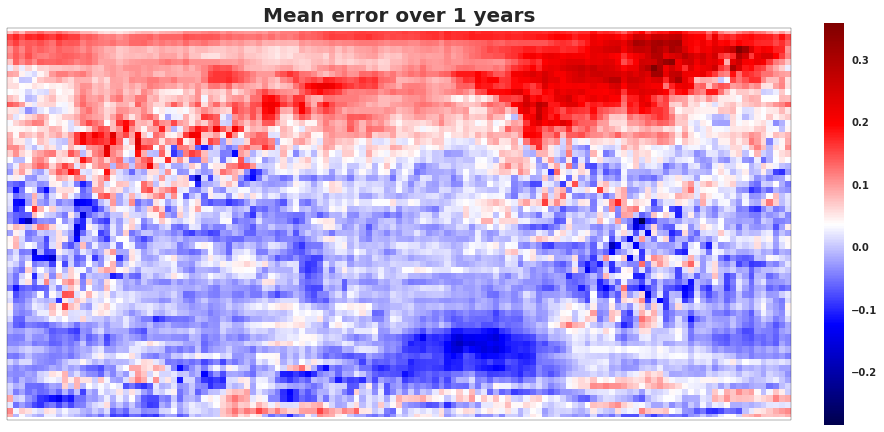

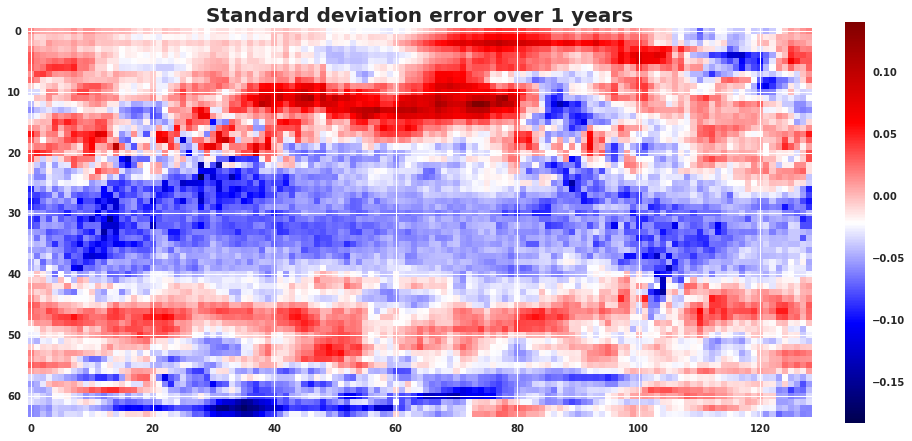

In [36]:
import cartopy.util

meanerr = cartopy.util.add_cyclic_point(mX-mXg, coord=lons, axis=1)[0]
print(meanerr[0])
stderr = cartopy.util.add_cyclic_point(sX-sXg, coord=lons, axis=1)[0]

import cartopy.crs as ccrs

plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
plt.title(f'Mean error over {years} years', fontsize=20, fontweight='bold')
im = plt.imshow(meanerr, cmap='seismic', transform=ccrs.PlateCarree(central_longitude=360.))
plt.colorbar(im, fraction=0.024, pad=0.04)
plt.figure(figsize=(15,15))
plt.title(f'Standard deviation error over {years} years', fontsize=20, fontweight='bold')
im = plt.imshow(stderr, cmap='seismic')
plt.colorbar(im, fraction=0.024, pad=0.04)

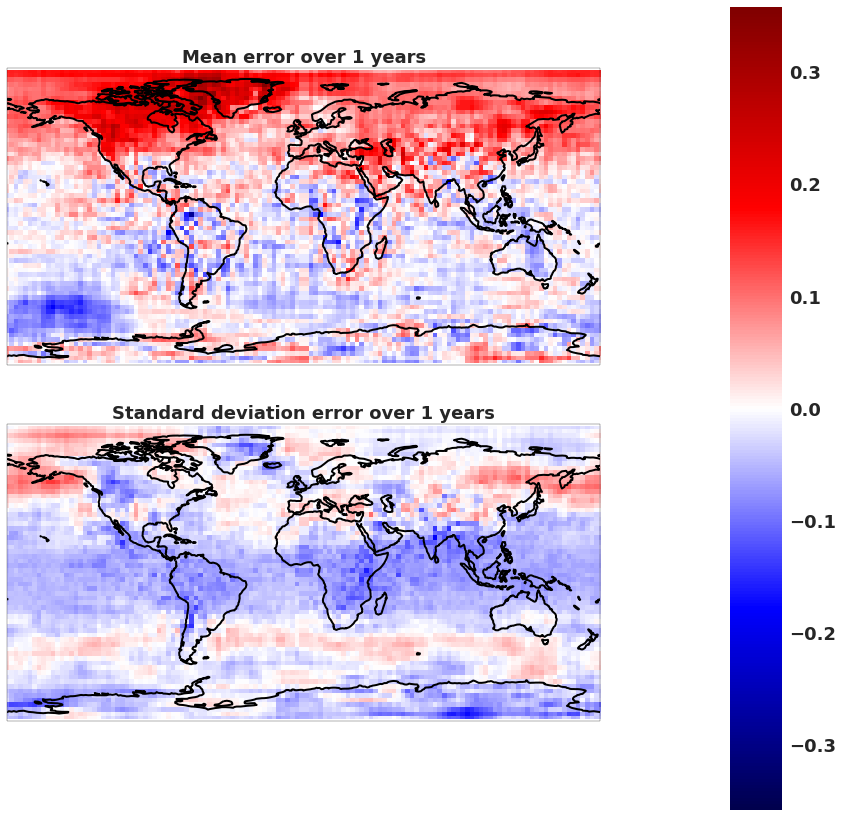

In [37]:
max_val = np.amax(np.asarray([np.abs(np.amin(mX-mXg)), np.abs(np.amax(mX-mXg)), np.abs(np.amax(mX-mXg)), np.abs(np.amin(mX-mXg)), 
                              np.abs(np.amin(sX-sXg)), np.abs(np.amax(sX-sXg)), np.abs(np.amax(sX-sXg)), np.abs(np.amin(sX-sXg))]))
fig, axs = plt.subplots(2,1, figsize=(24,12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
axs[0].coastlines(linewidth=2.)
ax = axs[0]
ax.grid(False)
ax.set_title(f'Mean error over {years} years', fontsize=18, fontweight='bold')
im1 = ax.imshow(meanerr[::-1,:], cmap='seismic', vmin=-max_val, vmax=max_val, transform=ccrs.PlateCarree(central_longitude=180.))
plt.axis('off')
posn0 = ax.get_position()
ax2 = axs[1]
axs[1].coastlines(linewidth=2.)
ax2.grid(False)
ax2.set_title(f'Standard deviation error over {years} years', fontsize=18, fontweight='bold')
im = ax2.imshow(stderr[::-1,:], vmin=-max_val, vmax=max_val, cmap='seismic', transform=ccrs.PlateCarree(central_longitude=180.))
plt.axis('off')
posn = ax2.get_position()
cax = fig.add_axes([posn.x1+0.075 , 0.022, 0.03, posn0.height*2+0.243])
cbar = plt.colorbar(im1, cax=cax)
cbar.ax.tick_params(labelsize=18)

if save:
    plt.savefig('./fig_82c/mean_std_climate_err.pdf')


In [38]:
print(f'Notebook run in {time.time()-start} seconds for {N_gen} samples')

NameError: name 'start' is not defined